### 0. Paths & libraries

In [1]:
import os
import sys

# Paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
utils_path = os.path.join(project_root, 'utils')
models_path = os.path.join(project_root, 'models')
data_path = os.path.join(project_root, 'data_sample')

# Add utils path to sys.path
sys.path.append(utils_path)

In [2]:
import time
import math
import random
from tqdm.notebook import tqdm  # Notebook-friendly version
import warnings
import joblib
warnings.filterwarnings("ignore")

# Data manipulation
import numpy as np
import rasterio as rio
import numpy as np
import pandas as pd
import data_preprocessing as dP

# Statistics
from scipy.stats import randint, uniform
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

# from osgeo import gdal
# from scipy import ndimage, datasets
from scipy.ndimage import binary_dilation,binary_opening
# from PIL import Image, ImageFilter

# Plotting
# import richdem as rd
# from glob import glob
# from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns
import viz as vz
import plotly.express as px
import plotly.express as px
# from IPython.display import display, HTML

# Preprocessing & pipelines
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import class_weight

# Model selection and optimization
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
import optuna

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC


# Métricas
from sklearn.metrics import balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay, classification_report, make_scorer, f1_score, confusion_matrix, cohen_kappa_score

### 1. Save & Load data

In [3]:
# Images and labels directories
image_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/images'
label_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/labels' 

# Select the number of images to be processed
M = float(input("Indicar porcentaje de imágenes a procesar (valor entre 0 y 1): "))

# Load data using user function. The images are selected randomly among the total number of avilable images (1631)
X, y = dP.process_images(M,image_dir,label_dir)

Image processing:   0%|          | 0/16 [00:00<?, ?it/s]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
[Image 1068.tif] Total: 0.06s | Load: 0.01s | SAR: 0.00s | Slope & Aspect: 0.03sLabel: 0.00s | Flatten & Stack: 0.01s
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top

In [4]:
X.head(5)

,VV,VH,VH_VV,VV_VH,NORM,DEM_mer,DEM_cop,SLOPE,ASPECT,WCM,WOP
0,729.0,693.0,0.950617,1.051948,-0.025316,43.0,59.0,0.0,270.0,10.0,0.0
1,1092.0,794.0,0.727106,1.375315,-0.158006,43.0,58.0,0.0,270.0,10.0,0.0
2,3234.0,685.0,0.211812,4.721168,-0.650421,45.0,57.0,500.0,270.0,10.0,0.0
3,2036.0,729.0,0.358055,2.792867,-0.472694,46.0,56.0,1000.0,180.0,30.0,0.0
4,693.0,575.0,0.829726,1.205217,-0.093060,49.0,55.0,0.0,270.0,10.0,0.0


In [5]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,4194304.0,1829.822510,2610.206543,0.0,803.000000,1286.000000,2021.000000,3.276500e+04
VH,4194304.0,394.023010,622.664001,0.0,185.000000,300.000000,467.000000,3.276500e+04
VH_VV,4194203.0,inf,NaN,0.0,0.137313,0.233616,0.388736,inf
VV_VH,4194203.0,inf,NaN,0.0,2.572438,4.280528,7.282609,inf
NORM,4194203.0,-0.576090,0.245788,-1.0,-0.758530,-0.621250,-0.440158,1.000000e+00
DEM_mer,4194304.0,144.896194,363.861938,1.0,24.000000,43.000000,82.000000,2.304000e+03
DEM_cop,4194304.0,146.053284,365.861816,0.0,24.000000,43.000000,84.000000,2.318000e+03
SLOPE,4194304.0,264.009338,494.662659,0.0,0.000000,0.000000,353.553406,4.472136e+03
ASPECT,4194304.0,239.548325,73.432137,0.0,270.000000,270.000000,270.000000,3.575104e+02
WCM,4194304.0,30.978273,14.414845,0.0,10.000000,30.000000,40.000000,1.000000e+02


#### 1.1 Save data

In [6]:
# X_path = os.path.join(data_path, 'X.pkl')
# y_path = os.path.join(data_path, 'y.pkl')

# X.to_pickle(X_path)
# y.to_pickle(y_path)

#### 1.2 Load data

In [7]:
# # Load X,y dataframes (10% of the total images)
# X_path = os.path.join(data_path, 'X.pkl') 
# y_path = os.path.join(data_path, 'y.pkl')
# X= pd.read_pickle(X_path)
# y = pd.read_pickle(y_path)

### 2. Cleaning

##### 2.2.1 Remove inf and Na values

In [8]:
# Remove NaN and infinite values
X_clean = X.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
y_clean = y.loc[X_clean.index].reset_index(drop=True)

In [9]:
X_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,4182628.0,1834.461914,2612.612061,1.000000,807.000000,1289.000000,2024.000000,32765.000000
VH,4182628.0,395.121033,623.238892,1.000000,186.000000,301.000000,468.000000,32765.000000
VH_VV,4182628.0,0.312143,0.327342,0.000305,0.138018,0.234195,0.389291,95.000000
VV_VH,4182628.0,6.439889,11.100066,0.010526,2.568773,4.269953,7.245424,3276.500000
NORM,4182628.0,-0.575052,0.244761,-0.999390,-0.757441,-0.620490,-0.439583,0.979167
DEM_mer,4182628.0,145.257767,364.332794,1.000000,24.000000,44.000000,82.000000,2304.000000
DEM_cop,4182628.0,146.421005,366.310242,0.000000,24.000000,43.000000,84.000000,2318.000000
SLOPE,4182628.0,264.552094,494.659546,0.000000,0.000000,0.000000,395.284698,4472.135742
ASPECT,4182628.0,239.482880,73.462395,0.000000,270.000000,270.000000,270.000000,357.510437
WCM,4182628.0,30.919592,14.355535,0.000000,10.000000,30.000000,40.000000,100.000000


In [10]:
print(X_clean.shape)
print(y_clean.shape)

(4182628, 11)
(4182628,)


##### 2.2.2 Remove No Data values (WCM & WOP)

In [11]:
# Drop rows with No Data Values for WCM and WOP columns
X_clean, y_clean = dP.drop_NoData_rows(X_clean, y_clean)

In [12]:
print(X_clean.shape)
print(y_clean.shape)

(4182615, 11)
(4182615,)


In [13]:
X_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,4182615.0,1834.464966,2612.614258,1.000000,807.000000,1289.000000,2024.000000,32765.000000
VH,4182615.0,395.121613,623.239502,1.000000,186.000000,301.000000,468.000000,32765.000000
VH_VV,4182615.0,0.312143,0.327342,0.000305,0.138018,0.234195,0.389291,95.000000
VV_VH,4182615.0,6.439882,11.100072,0.010526,2.568773,4.269953,7.245410,3276.500000
NORM,4182615.0,-0.575052,0.244761,-0.999390,-0.757441,-0.620490,-0.439583,0.979167
DEM_mer,4182615.0,145.258072,364.333282,1.000000,24.000000,44.000000,82.000000,2304.000000
DEM_cop,4182615.0,146.421478,366.310822,0.000000,24.000000,43.000000,84.000000,2318.000000
SLOPE,4182615.0,264.552399,494.659607,0.000000,0.000000,0.000000,395.284698,4472.135742
ASPECT,4182615.0,239.482803,73.462471,0.000000,270.000000,270.000000,270.000000,357.510437
WCM,4182615.0,30.919586,14.355376,10.000000,10.000000,30.000000,40.000000,100.000000


### 3. Train-test split

In [14]:
# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state= 43, stratify=y_clean) 

print(X_train.shape)
print(y_train.shape)

(3346092, 11)
(3346092,)


### 4. Variable target

In [15]:
y_train.value_counts(normalize=True)*100

Labels
0.0    95.695815
1.0     4.304185
Name: proportion, dtype: float64

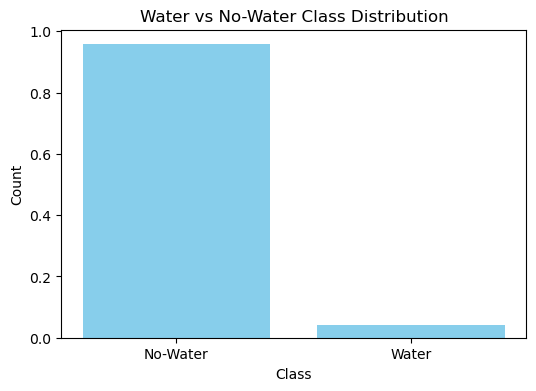

In [16]:
# Calculate frequency of each class
label_freq = y_train.value_counts(normalize=True).sort_index()

# Create mapping
label_names = {0.0: 'No-Water', 1.0: 'Water'}
label_names_list = [label_names[val] for val in label_freq.index]

# Plot
plt.figure(figsize=(6,4))
plt.bar(label_names_list, label_freq.values, color='skyblue')
plt.title('Water vs No-Water Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

Las clases están muy desbalanceadas, siendo la clase target o positiva (water) la de menor proporción

### 5. Undersampling

In [17]:
# Undersampling
datos = X_train
datos['Labels'] = y_train

#Extraemos los pixeles con agua y los sin agua
agua = datos[datos['Labels']==1]
no_agua = datos[datos['Labels']==0]

#Cogemos dos datasets iguales
agua_sam = agua.sample(n = len(agua))
no_agua_sam = no_agua.sample(n = len(agua))

#Concatenamos los datasets
datos= pd.concat([agua_sam, no_agua_sam], axis=0,ignore_index=True)

# Mezclamos los datos (shuffle)
# datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = datos.drop('Labels',axis='columns')
y_train_bal = datos['Labels']

y_train_bal.value_counts(normalize=True)

Labels
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

### 6. Features

#### 6.1 Feature selection

In [18]:
X_train_bal.columns

Index(['VV', 'VH', 'VH_VV', 'VV_VH', 'NORM', 'DEM_mer', 'DEM_cop', 'SLOPE',
       'ASPECT', 'WCM', 'WOP'],
      dtype='object')

In [19]:
# Feature selection
col_to_exclude = input("Cols to exclude, or Esc if not: ").split(',')

features = [col for col in X_train_bal.columns if col not in col_to_exclude]

# Features selected
print('Features selected:')
print(features)

Features selected:
['VV', 'VH', 'DEM_cop', 'WCM']


In [20]:
X_train_sel = X_train_bal[features]
X_test_sel = X_test[features]

#### 6.2 Features transformations

In [21]:
X_train_sel

,VV,VH,DEM_cop,WCM
0,1456.0,88.0,55.0,40.0
1,1579.0,196.0,79.0,40.0
2,944.0,139.0,4.0,80.0
3,768.0,159.0,15.0,40.0
4,921.0,452.0,13.0,40.0
...,...,...,...,...
288039,793.0,290.0,39.0,40.0
288040,2390.0,247.0,126.0,10.0
288041,787.0,250.0,95.0,10.0
288042,2150.0,577.0,50.0,10.0


In [22]:
# scaler
scaler = MinMaxScaler()

# Transform with the scaler
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)

In [23]:
X_train_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,288044.0,0.046909,0.066155,0.0,0.020175,0.034550,0.054999,1.0
VH,288044.0,0.009884,0.015922,0.0,0.004212,0.007630,0.012331,1.0
DEM_cop,288044.0,0.039223,0.120931,0.0,0.006929,0.012993,0.024686,1.0
WCM,288044.0,0.260461,0.183626,0.0,0.222222,0.333333,0.333333,1.0


### 7. MLP

In [24]:
# Numpy transformation for Tensorflow + GPU
y_train_np = np.array(y_train_bal).astype(np.float32).ravel()
y_test_np = np.array(y_test).astype(np.float32).ravel()

In [25]:
# # --- Compute class weights ---
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_np),
#     y=y_train_np
# )
# class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [26]:
X_train = X_train_scaled
X_test = X_test_scaled

y_train = y_train_np
y_test = y_test_np

In [27]:
print(X_train.shape)
print(y_train.shape)

(288044, 4)
(288044,)


#### 7.1 MLP construction 

In [28]:
# ---- User inputs ----
ep = int(input("Nº máximo de épocas: "))
lr = float(input("Learning rate (Default value=0.001): "))
md = 0.001  # Set your min_delta for early stopping here

In [29]:
# ---- Train-validation split ----
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [30]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(X_train.shape[1],))) # Input Layer

model.add(keras.layers.Dense(units=16, activation = 'relu')) # Dense layer

model.add(keras.layers.Dense(units=8, activation = 'relu')) # Dense layer

model.add(keras.layers.Dense(units=4, activation = 'sigmoid')) # Dense layer

model.add(keras.layers.Dense(units=1)) # Output layer

In [31]:
adam_optimizer = keras.optimizers.Adam(learning_rate= lr, beta_1= 0.9, beta_2 = 0.999)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=md,
    patience=10,
    restore_best_weights=True,
    verbose=1)

In [32]:
model.compile(optimizer = adam_optimizer,
              loss = keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['binary_accuracy',Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

In [33]:
model.compile(
    optimizer=adam_optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'binary_accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


#### 7.2 Training

In [35]:
# ---- Train model ----
print("Fit model on training data")
history = model.fit(
    X_train_final,
    y_train_final,
    batch_size=256,
    epochs=ep,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Fit model on training data
Epoch 1/50
901/901 [==============================] - 6s 6ms/step - loss: 0.5888 - binary_accuracy: 0.6441 - precision: 0.7270 - recall: 0.4615 - auc: 0.7113 - val_loss: 0.5582 - val_binary_accuracy: 0.6647 - val_precision: 0.7812 - val_recall: 0.4574 - val_auc: 0.7348
Epoch 2/50
901/901 [==============================] - 5s 6ms/step - loss: 0.5511 - binary_accuracy: 0.6767 - precision: 0.7626 - recall: 0.5133 - auc: 0.7402 - val_loss: 0.5467 - val_binary_accuracy: 0.6702 - val_precision: 0.7924 - val_recall: 0.4612 - val_auc: 0.7365
Epoch 3/50
901/901 [==============================] - 7s 8ms/step - loss: 0.5445 - binary_accuracy: 0.6760 - precision: 0.7738 - recall: 0.4974 - auc: 0.7449 - val_loss: 0.5441 - val_binary_accuracy: 0.6648 - val_precision: 0.8220 - val_recall: 0.4207 - val_auc: 0.7385
Epoch 4/50
901/901 [==============================] - 6s 7ms/step - loss: 0.5306 - binary_accuracy: 0.6974 - precision: 0.7908 - recall: 0.5369 - auc: 0.7544 - val

#### 7.3 Save the model

In [36]:
# # Save the model
# model_filename = os.path.join(models_path, 'MLP_model.pkl')
# joblib.dump(model, model_filename)

### 8. Evaluate

#### 8.1 Model training overview

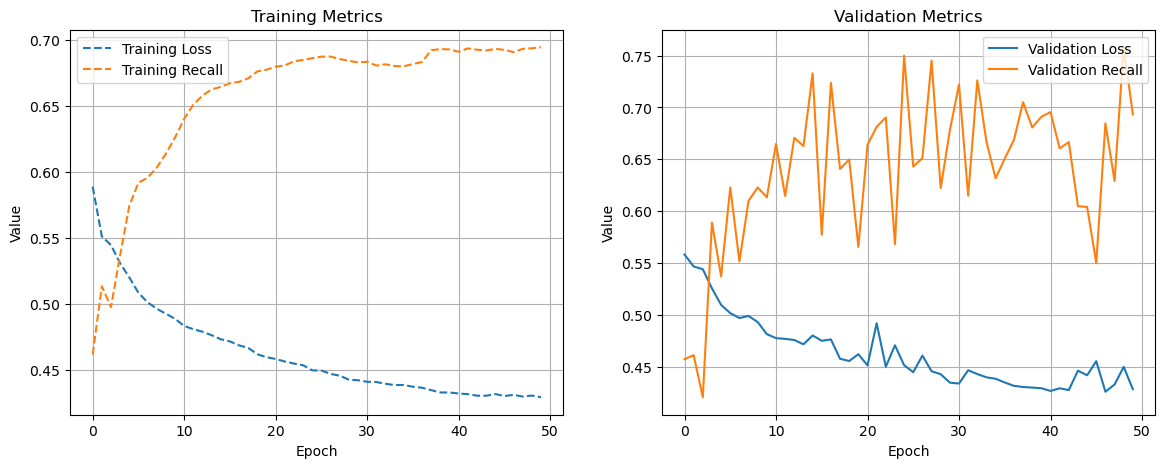

In [37]:
# Convert history to DataFrame
history_df = pd.DataFrame(history.history)

# Set up the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# --- Training Metrics Plot ---
axs[0].plot(history_df['loss'], label='Training Loss', linestyle='--')
axs[0].plot(history_df['recall'], label='Training Recall', linestyle='--')
axs[0].set_title('Training Metrics')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

# --- Validation Metrics Plot ---
axs[1].plot(history_df['val_loss'], label='Validation Loss')
axs[1].plot(history_df['val_recall'], label='Validation Recall')
axs[1].set_title('Validation Metrics')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

#### 8.2 Evaluate on validation dataset

In [38]:
classes = ['no_Water','Water']

# Evaluate on the val set
y_val_probs = model.predict(X_val)
y_val_preds = (y_val_probs > 0.5).astype(int)

# Metrics
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_preds,target_names=classes))

1801/1801 [==============================] - 2s 1ms/step

Validation Classification Report:
              precision    recall  f1-score   support

    no_Water       0.74      0.88      0.80     28805
       Water       0.85      0.69      0.76     28804

    accuracy                           0.78     57609
   macro avg       0.79      0.78      0.78     57609
weighted avg       0.79      0.78      0.78     57609



#### 8.3 Evaluate on test dataset

In [39]:
# Evaluate on the test set
y_test_probs = model.predict(X_test)
y_test_preds = (y_test_probs > 0.5).astype(int)


print("Results obtained for:")
print(f"Trained data. {M}")
print(f"Learning rate: {lr}")
print(f"Selected features: {features}")

# Metrics
Kappa=cohen_kappa_score(y_test, y_test_preds)
accuracy = accuracy_score(y_test, y_test_preds)

print(f"Test Accuracy: {accuracy}")
print(f"Test Kappa: {Kappa}")

print("\nValidation Classification Report:")
print(classification_report(y_test, y_test_preds,target_names=classes))

26142/26142 [==============================] - 32s 1ms/step
Results obtained for:
Trained data. 0.01
Learning rate: 0.01
Selected features: ['VV', 'VH', 'DEM_cop', 'WCM']
Test Accuracy: 0.8684614768512043
Test Kappa: 0.26279287149013186

Validation Classification Report:
              precision    recall  f1-score   support

    no_Water       0.98      0.88      0.93    800517
       Water       0.20      0.69      0.31     36006

    accuracy                           0.87    836523
   macro avg       0.59      0.78      0.62    836523
weighted avg       0.95      0.87      0.90    836523



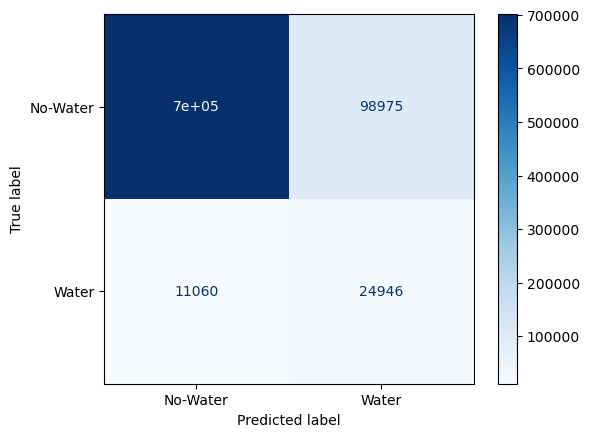

In [40]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_preds)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No-Water", "Water"])
disp.plot(cmap="Blues")

#### 7.4 Evaluate in an image

In [41]:
# Repetimos para una imagen
num_file = 90
img_df, label, row, col = dP.process_img(num_file)
img_df_selected = img_df[features]

img_proba = model.predict(img_df_selected)

#Convertimos las probabilidades en 0 y 1
img_pred = [1 if i > .5 else 0 for i in img_proba]

# Reshape to 512x512 image and opening filtering, the flatten to evaluate
img_pred = np.reshape(img_pred,(row,col))
img_pred = binary_opening(img_pred)
img_pred = np.reshape(img_pred,(row*col))

# Metrics
Kappa=cohen_kappa_score(label, img_pred)
accuracy = accuracy_score(label, img_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Test Kappa: {Kappa}")
print("\nClassification Report :")
print(classification_report(label, img_pred, target_names=classes))


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
8192/8192 [==============================] - 10s 1ms/step
Test Accuracy: 0.9180755615234375
Test Kappa: -0.016051545097552244

Classification Report :
              precision    recall  f1-score   support

    no_Water       0.93      0.99      0.96    243151
       Water       0.00      0.00      0.00     18993

    accuracy                           0.92    262144
   macro avg       0.47      0.50      0.48    262144
weighted avg       0.86      0.92      0.89    262144



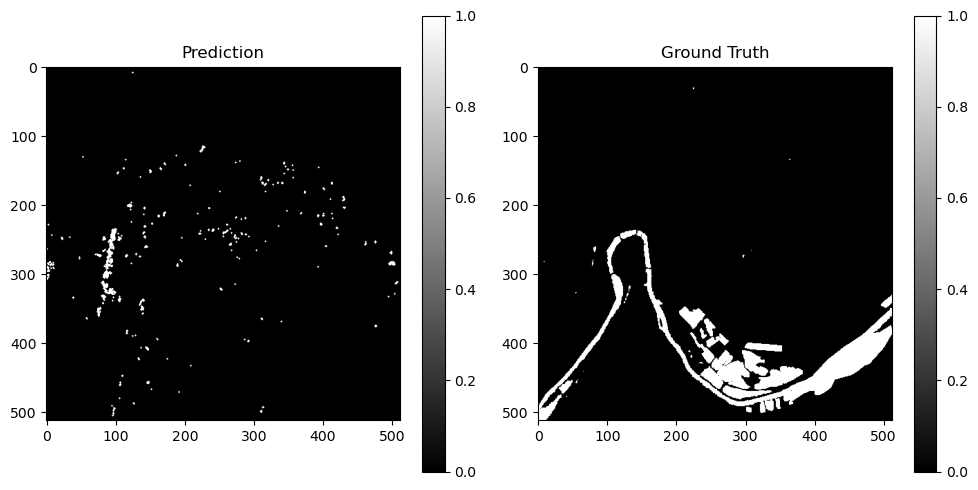

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


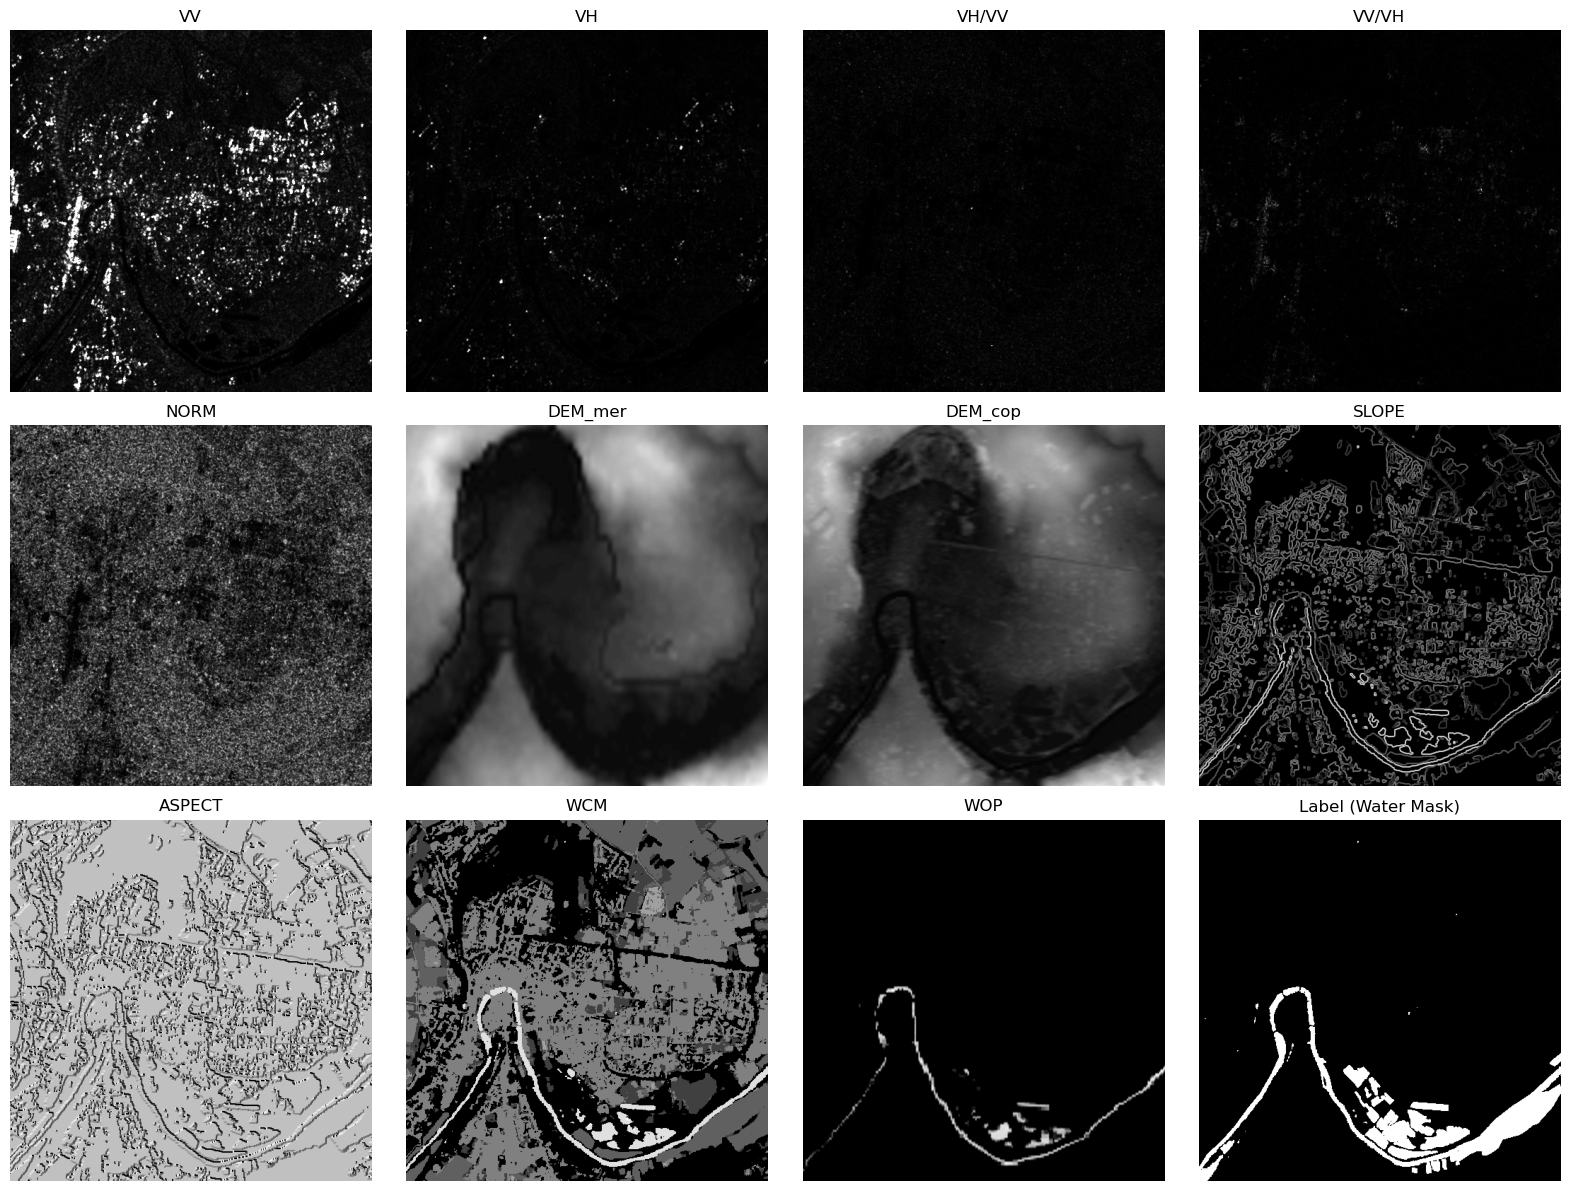

In [42]:
# Reshape to viz
img_pred = np.reshape(img_pred,(row,col))
label = np.reshape(label,(row,col))

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Prediction image
im1 = axs[0].imshow(img_pred, cmap='gray')
axs[0].set_title('Prediction')
fig.colorbar(im1, ax=axs[0])

# Ground truth label
im2 = axs[1].imshow(label, cmap='gray')
axs[1].set_title('Ground Truth')
fig.colorbar(im2, ax=axs[1])

# Show the plots
plt.tight_layout()
plt.show()

image_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/images'
label_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/labels' 
vz.visualize_features(num_file, image_dir,label_dir)